In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style='ticks', context='talk')
# fix slow autocomplete
%config Completer.use_jedi = False
pd.options.display.max_columns=300
pd.options.display.max_rows=300

In [47]:
from patchseq_utils import analysis as utils, plotting as plot
from patchseq_utils import l1_load, util, lims
from importlib import reload
reload(l1_load)
reload(util)
from patchseq_utils.util import *

<module 'patchseq_utils.util' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/util.py'>

In [48]:
# load L1 dataset
from patchseq_utils.l1_load import *

In [50]:
# alternative load all human inh patch-seq then filter

# dataset_list = pd.read_csv(f"~/projects/human_l1/human_l1_dataset_2022_06_22.csv", index_col=0).index
# df = get_full_human_metadata_df().loc[dataset_list]
# then join to ephys and morpho features

# also be sure to change the figdir to not overwrite mine!
# figdir = Path('.')

In [8]:
donor = 'donor_name'
donors = lims.get_donor_info(human_df[donor].unique()).set_index('name')
donors.head()
donors['medical_condition'].value_counts(dropna=False)

disease categories - epilepsy         70
disease categories - tumor            50
NaN                                   18
disease categories - hydrocephalus     5
Tumor status - primary                 3
Epileptiform Events                    1
Name: medical_condition, dtype: int64

In [9]:
def condition(x):
    if pd.isna(x):
        return x
    elif 'tumor' in x.lower():
        return 'tumor'
    elif 'epilep' in x.lower():
        return 'epilepsy'
    elif 'hydrocephalus' in x:
        return 'hydrocephalus'
    else:
        return x
    
def epileptic(x):
    if pd.isna(x):
        return x
    elif 'epilep' in x.lower():
        return 'epileptic'
    else:
        return 'non-epileptic'
donors['condition'] = donors['medical_condition'].map(condition)
donors['epileptic'] = donors['medical_condition'].map(epileptic)
human_df = human_df.join(donors, on=donor, rsuffix='_r')

In [25]:
epilepsy_palette = {'epileptic': 'red', 'non-epileptic':'blue'}

# Brain area

In [6]:
def lobe(x):
    if any((y in x for y in ['Tem', 'TG', 'PLP', 'PRG', 'PaCG'])): 
        return 'TemL'
    elif any((y in x for y in ['Fro', 'OrG', 'FG'])): 
        return 'Occ/FroL'
    elif any((y in x for y in ['Occ', 'OG', 'FG'])): 
        return 'Occ/FroL'
    elif any((y in x for y in ['AnG', 'Par'])): 
        return 'ParL'
    else:
        return None
human_df['cortical_lobe'] = human_df['structure'].fillna('').map(lobe)
human_df.query('has_morph')['cortical_lobe'].value_counts(dropna=False)
# exclude SPL (parietal) and OccL??

TemL        63
Occ/FroL    19
ParL         2
NaN          2
Name: cortical_lobe, dtype: int64

In [10]:
# query hack for missing values x==x
x = human_df.query("((collaborator=='AIBS' & failed_fx_long_squares==False) | has_morph) & structure!=structure")[
    ['cell_name', 'donor_name','slice', cluster, 'layer', 'target_layer', 'has_morph', 'collaborator', 'roi', 'condition']
]
# x.to_csv('need_pin.csv')
x

,cell_name,donor_name,slice,t-type,layer,target_layer,has_morph,collaborator,roi,condition
spec_id,,,,,,,,,,
1004840833,H20.28.001.11.05.05,H20.28.001,H20.28.001.11.05,LAMP5 NMBR,1,1,True,Gabor,OCx_L1,hydrocephalus
1004840721,H20.28.001.11.05 .01,H20.28.001,H20.28.001.11.05,NaN,1,1,True,Gabor,OCx_L1,hydrocephalus
665703417,H18.03.003.11.11.02,H18.03.003,H18.03.003.11.11,LAMP5 NMBR,1,1,False,AIBS,TCx_L1,tumor
1154338548,H22.26.404.11.06.02.01,H22.26.404,H22.26.404.11.06.02,ADARB2 MC4R,None,1,False,AIBS,FCx_L1,tumor
665695931,H18.03.003.11.05.01,H18.03.003,H18.03.003.11.05,VIP PCDH20,1,2,False,AIBS,TCx_L2,tumor
1111401181,H21.06.353.11.04.01.02,H21.06.353,H21.06.353.11.04.01,PAX6 TNFAIP8L3,None,1,False,AIBS,TCx_L1,tumor


In [11]:
human_df.query("collaborator=='AIBS'").structure.value_counts()

MTG      164
TemL      38
ITG       24
SFG       18
STG       14
MFG        9
PRG        4
IFGtr      3
PaCG       2
SPL        1
OccL       1
PLP        1
LOrG       1
Name: structure, dtype: int64

In [12]:
human_df.query("has_morph").structure.value_counts()

MTG     38
TemL    13
ITG      8
SFG      7
FroL     4
MFG      3
IFG      2
SOG      2
PaCG     2
STG      1
ParL     1
PRG      1
AnG      1
IOG      1
Name: structure, dtype: int64

## proportions

In [5]:
import scipy.stats as stats

def df_fisher(df, cluster, meta, cluster_name, test=stats.fisher_exact):
    ct = pd.crosstab(df[meta], df[cluster]==cluster_name)
    out = test(ct)
    
    return out.pvalue if hasattr(out, 'pvalue') else out[1]

def fisher_test_all(df, cluster, meta, test=stats.fisher_exact):
    df = df.dropna(subset=[cluster])
    names = df[cluster].unique()
    return pd.Series({cluster_name: df_fisher(df, cluster, meta, cluster_name, test) 
           for cluster_name in names}).sort_values()

In [45]:
df = human_df.query("layer=='1' & collaborator=='AIBS'")
group_col = 'structure'
df[group_col].value_counts(dropna=False)

MTG      126
TemL      24
ITG       22
SFG       13
MFG        5
STG        4
PRG        3
IFGtr      3
NaN        2
LOrG       1
OccL       1
SPL        1
Name: structure, dtype: int64

In [137]:
data = pd.get_dummies(df, columns=[group_col])

In [139]:
fisher_test_all(data, 'homology_type', 'structure_MTG')

LAMP5     0.024934
MC4R      0.047427
PAX6      0.263020
other     0.579569
L1 VIP    0.788824
dtype: float64

In [144]:
pd.crosstab(data['structure_MTG'], data['homology_type'])

homology_type,PAX6,LAMP5,MC4R,L1 VIP,other
structure_MTG,,,,,
0,11,41,7,5,7
1,27,48,25,10,8


In [140]:
fisher_test_all(data, 'homology_type', 'structure_ITG')

PAX6      0.257688
LAMP5     0.261494
other     0.688103
MC4R      0.770665
L1 VIP    1.000000
dtype: float64

In [145]:
fisher_test_all(data, 'homology_type', 'structure_TemL')

LAMP5     0.020921
MC4R      0.027576
PAX6      0.577572
other     0.675215
L1 VIP    1.000000
dtype: float64

In [147]:
pd.crosstab(data['structure_TemL'], data['homology_type'])

homology_type,PAX6,LAMP5,MC4R,L1 VIP,other
structure_TemL,,,,,
0,35,74,32,14,13
1,3,15,0,1,2


## Ephys

In [13]:
df = human_df.query("l1_type & collaborator=='AIBS' & failed_fx_long_squares==False")
group_col = 'structure'
order = ['ITG','MTG','STG','MFG','SFG']
data = subset_data(df, ephys_features, cluster=group_col, ephys_frac_min=0, cluster_min=5).query("structure!='TemL'")
data[group_col] = pd.Categorical( data[group_col], categories=order, ordered=True)
data[group_col].value_counts()

MTG    137
ITG     23
SFG     16
STG      9
MFG      7
Name: structure, dtype: int64

In [14]:
features = subset_features(data, ephys_features, complete_frac=0.5)
# features = ephys_features
res = utils.run_kw_dunn(data, features, group_col)
res.to_csv(figdir/'supp_tables'/'md_region_ephys.csv')
res.head(20)

,KW_H,pval,epsilon2,pval_fdr,pairs,ipairs,pair_count
feature,,,,,,,
avg_rate_max,19.794452,0.000548,0.103636,0.036796,"[(ITG, MTG), (ITG, SFG), (MTG, STG), (MTG, MFG...","[01, 04, 12, 13, 24, 34]",6
input_resistance_ss,18.679305,0.000909,0.098832,0.036796,"[(MTG, MFG), (MFG, SFG)]","[13, 34]",2
downstroke_adapt_ratio,17.461218,0.001572,0.091901,0.042447,[],[],0
width_adapt_ratio,16.573811,0.002338,0.087231,0.047352,"[(MTG, STG)]",[12],1
threshold_i_ramp,15.922855,0.003124,0.083804,0.050616,None,None,None
trough_v_ramp,13.209257,0.010297,0.069522,0.104371,None,None,None
downstroke_rheo,13.032573,0.011118,0.068233,0.104371,None,None,None
downstroke_ramp,12.963648,0.011455,0.068230,0.104371,None,None,None
avg_rate_hero,12.919714,0.011675,0.067642,0.104371,None,None,None


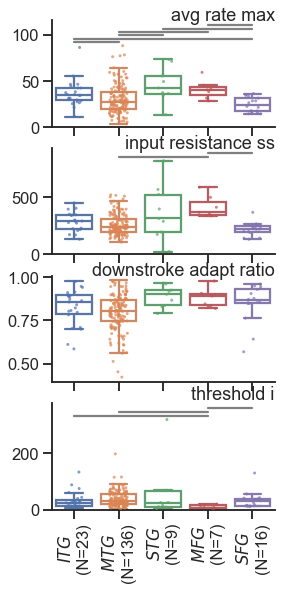

In [140]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res.index, corr, nfeat=4, threshold=0.7)
utils.plot_boxplot_multiple(data, feat, group_col, labels=feature_name, test='dunn', figsize=(4,9))

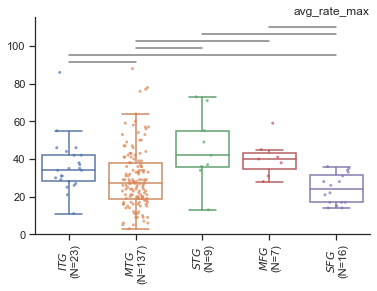

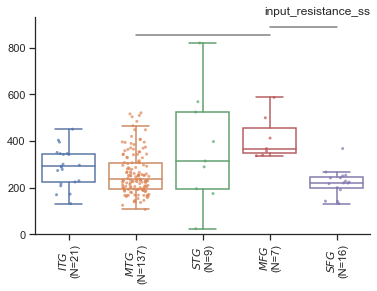

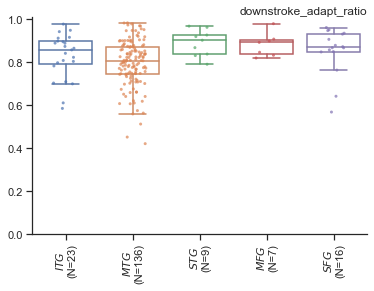

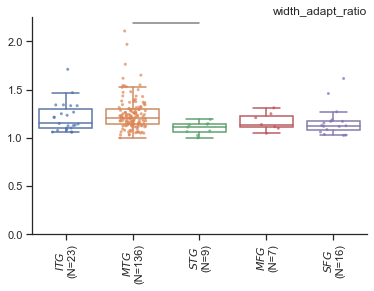

In [109]:
for f in res.loc[lambda df: df['pair_count'].notna()].index:
    utils.plot_box_cluster_feature(data, f, group_col, test='dunn')

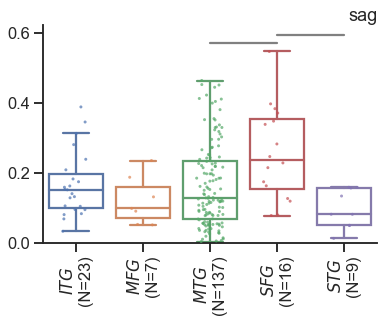

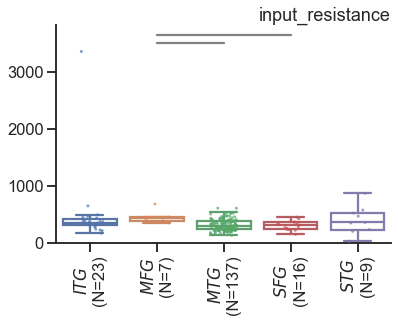

In [64]:
features = [
    'sag',
    'input_resistance'
]
for f in features:
    utils.plot_box_cluster_feature(data, f, group_col, test='dunn')

## Morpho

In [120]:
df = human_df.query("l1_type")
group_col = 'structure'
data = subset_data(df, morph_features, cluster=group_col, ephys_frac_min=0, cluster_min=5).query("structure!='TemL'")
# order = ['ITG','MTG','STG','MFG','SFG']
# data[group_col] = pd.Categorical( data[group_col], categories=order, ordered=True)
data[group_col].value_counts()

MTG    35
ITG     8
SFG     7
Name: structure, dtype: int64

In [121]:
features = morph_features
res = utils.run_kw_dunn(data, features, group_col)
res.to_csv(figdir/'supp_tables'/'md_region_morpho.csv')
res.head(20)

,KW_H,pval,epsilon2,pval_fdr,pairs,ipairs,pair_count
feature,,,,,,,
axon_exit_theta,10.683832,0.004787,0.218037,0.101565,None,None,None
basal_dendrite_extent_y,9.855176,0.007244,0.201126,0.101565,None,None,None
basal_dendrite_mean_contraction,9.579277,0.008315,0.195495,0.101565,None,None,None
basal_dendrite_max_euclidean_distance,9.393328,0.009126,0.191701,0.101565,None,None,None
basal_dendrite_total_length,9.028017,0.010954,0.184245,0.101565,None,None,None
basal_dendrite_max_path_distance,8.854252,0.011949,0.180699,0.101565,None,None,None
axon_soma_percentile_x,7.940975,0.018864,0.162061,0.123703,None,None,None
basal_dendrite_total_surface_area,7.882353,0.019425,0.160864,0.123703,None,None,None
axon_over_basal_dendrite_extent_x,7.648941,0.021830,0.156101,0.123703,None,None,None


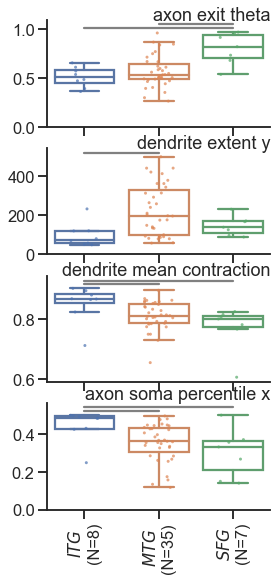

In [137]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res.index, corr, nfeat=4, threshold=0.7)
utils.plot_boxplot_multiple(data, feat, group_col, labels=feature_name, test='dunn', figsize=(4,9))

In [315]:
df = human_df.query("l1_type")
group_col = 'cortical_lobe'
data = subset_data(df, morph_features, cluster=group_col, ephys_frac_min=0, cluster_min=2)#.query("structure!='TemL'")
# order = ['ITG','MTG','STG','MFG','SFG']
# data[group_col] = pd.Categorical( data[group_col], categories=order, ordered=True)
data[group_col].value_counts()

TemL    59
FroL    12
OccL     3
ParL     2
Name: cortical_lobe, dtype: int64

In [316]:
features = morph_features
res = utils.run_kw_dunn(data, features, group_col)
# res.to_csv(figdir/'supp_tables'/'md_region_morpho.csv')
res.head(20)

,KW_H,pval,epsilon2,pval_fdr,pairs,ipairs,pair_count
feature,,,,,,,
axon_exit_theta,8.750345,0.032801,0.116671,0.871517,None,None,None
basal_dendrite_frac_intersect_axon,7.572154,0.055733,0.100962,0.871517,None,None,None
basal_dendrite_calculate_number_of_stems,7.143307,0.067468,0.095244,0.871517,None,None,None
basal_dendrite_num_branches,7.113912,0.068354,0.094852,0.871517,None,None,None
basal_dendrite_frac_above_axon,5.525600,0.137115,0.073675,0.962254,None,None,None
soma_aligned_dist_from_pia,4.955162,0.175110,0.066069,0.962254,None,None,None
axon_max_euclidean_distance,4.928062,0.177141,0.065707,0.962254,None,None,None
axon_emd_with_basal_dendrite,4.809719,0.186273,0.064130,0.962254,None,None,None
basal_dendrite_total_surface_area,4.542868,0.208498,0.060572,0.962254,None,None,None


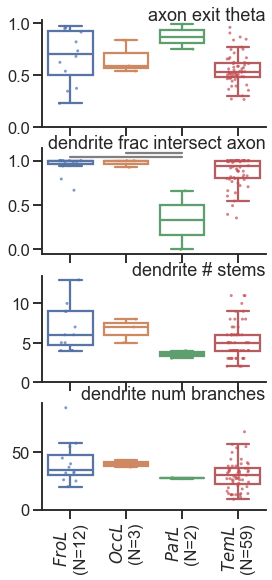

In [317]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res.index, corr, nfeat=4, threshold=0.7)
utils.plot_boxplot_multiple(data, feat, group_col, labels=feature_name, test='dunn', figsize=(4,9))

In [120]:
df = human_df.query("l1_type")
group_col = 'structure'
data = subset_data(df, morph_features, cluster=group_col, ephys_frac_min=0, cluster_min=5).query("structure!='TemL'")
# order = ['ITG','MTG','STG','MFG','SFG']
# data[group_col] = pd.Categorical( data[group_col], categories=order, ordered=True)
data[group_col].value_counts()

MTG    35
ITG     8
SFG     7
Name: structure, dtype: int64

In [121]:
features = morph_features
res = utils.run_kw_dunn(data, features, group_col)
res.to_csv(figdir/'supp_tables'/'md_region_morpho.csv')
res.head(20)

,KW_H,pval,epsilon2,pval_fdr,pairs,ipairs,pair_count
feature,,,,,,,
axon_exit_theta,10.683832,0.004787,0.218037,0.101565,None,None,None
basal_dendrite_extent_y,9.855176,0.007244,0.201126,0.101565,None,None,None
basal_dendrite_mean_contraction,9.579277,0.008315,0.195495,0.101565,None,None,None
basal_dendrite_max_euclidean_distance,9.393328,0.009126,0.191701,0.101565,None,None,None
basal_dendrite_total_length,9.028017,0.010954,0.184245,0.101565,None,None,None
basal_dendrite_max_path_distance,8.854252,0.011949,0.180699,0.101565,None,None,None
axon_soma_percentile_x,7.940975,0.018864,0.162061,0.123703,None,None,None
basal_dendrite_total_surface_area,7.882353,0.019425,0.160864,0.123703,None,None,None
axon_over_basal_dendrite_extent_x,7.648941,0.021830,0.156101,0.123703,None,None,None


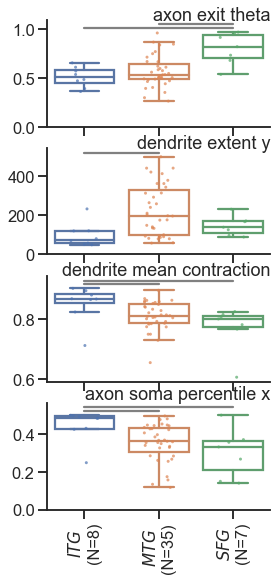

In [137]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res.index, corr, nfeat=4, threshold=0.7)
utils.plot_boxplot_multiple(data, feat, group_col, labels=feature_name, test='dunn', figsize=(4,9))

# medical condition

## Proportions

In [128]:
data = df.query("layer=='1'")
fisher_test_all(data, 'homology_type', group_col)

L1 VIP    0.016887
LAMP5     0.149690
PAX6      0.179659
MC4R      0.336454
other     1.000000
dtype: float64

In [125]:
pd.crosstab(data[group_col], df[cluster]=='VIP TSPAN12')

t-type,False,True
condition,,
epilepsy,142,8
tumor,32,7


In [118]:
data = subset_data(df.query("failed_fx_long_squares==False"),
                   ephys_features, cluster=group_col, ephys_frac_min=0, cluster_min=5)
data[group_col].value_counts(dropna=False)

epilepsy    190
tumor        46
Name: condition, dtype: int64

## ephys

In [196]:
data = human_df.query("l1_type & collaborator=='AIBS' & failed_fx_long_squares==False")
group_col = 'condition'
data[group_col].value_counts(dropna=False)

epilepsy    187
tumor        46
Name: condition, dtype: int64

In [187]:
features = subset_features(data, ephys_features, complete_frac=0.4)
res = utils.run_twosamp(data, features, group_col, fdr_method='fdr_bh')
res.to_csv(figdir/'supp_tables'/'md_medical_ephys.csv')
res.head(20)

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
sag_tau,0.037095,0.229730,0.614865,0.026831,0.421094,182,0.603706,0.856876
isi_cv_hero,0.056283,0.182183,0.591092,0.005710,0.454309,230,0.256929,0.856876
phase_peak_chirp,0.068969,0.277056,0.638528,0.003609,0.754844,95,0.256929,0.856876
postap_slope_ramp,0.088855,0.162225,0.581113,0.113890,0.261033,232,0.759376,0.856876
trough_slowdeltav_hero,0.108661,0.152871,0.576436,0.187135,0.217861,233,0.759376,0.856876
low_freq_impedance_chirp,0.111677,0.242424,0.621212,0.026600,0.580563,95,0.603706,0.856876
isi_cv_mean,0.131003,0.143920,0.571960,0.179897,0.221475,233,0.759376,0.856876
peak_impedance_chirp,0.137217,0.226551,0.613276,0.287597,0.281281,95,0.759376,0.856876
width_rheo,0.168201,0.131249,0.565624,0.154610,0.235020,233,0.759376,0.856876


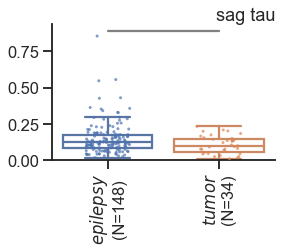

In [197]:
fig, ax = plt.subplots( figsize=(4,2.5))
utils.plot_box_cluster_feature(data, 'sag_tau', group_col, label='sag tau', test='dunn', ax=ax)

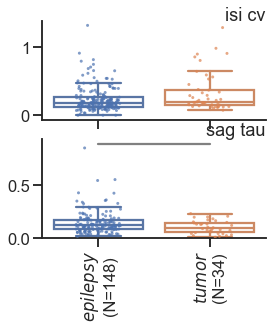

In [ ]:
feat = [
        'isi_cv_hero',
    'sag_tau', 
       ]
utils.plot_boxplot_multiple(data, feat, group_col, labels=feature_name, test='dunn', figsize=(4,4))

### Interaction

In [466]:
data = human_df.query("l1_type & collaborator=='AIBS' & failed_fx_long_squares==False")
groups='homology_type'
compare='epileptic'
data.groupby(groups)[compare].value_counts(dropna=False)

homology_type  epileptic    
PAX6           epileptic         27
               non-epileptic     13
LAMP5          epileptic        101
               non-epileptic     17
MC4R           epileptic         30
               non-epileptic      6
L1 VIP         epileptic         12
               non-epileptic      8
other          epileptic         17
               non-epileptic      2
Name: epileptic, dtype: int64

In [469]:
features = subset_features(data, ephys_features, complete_frac=0.4)
res = utils.run_species_subclass_stats(data, features, compare=compare, group_var=groups, anova_type=1, 
                                       compare_first=False, )
res.head()

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in true_divide
  self.het_scale = (self.wresid / (1 - h))**2


,eta_p_epileptic,pval_epileptic,pval_homology_type:epileptic,rsquared,interaction,sig_groups,PAX6,LAMP5,MC4R,other,L1 VIP
feature,,,,,,,,,,,
sag,0.041603,0.170584,0.540245,0.634737,False,NaN,NaN,NaN,NaN,NaN,NaN
tau,0.032059,0.208580,0.992319,0.336115,False,NaN,NaN,NaN,NaN,NaN,NaN
isi_cv_hero,0.031811,0.208580,0.818406,0.172790,False,NaN,NaN,NaN,NaN,NaN,NaN
input_resistance_ss,0.027656,0.261026,0.992319,0.140741,False,NaN,NaN,NaN,NaN,NaN,NaN
input_resistance,0.018115,0.715898,0.992319,0.150349,False,NaN,NaN,NaN,NaN,NaN,NaN


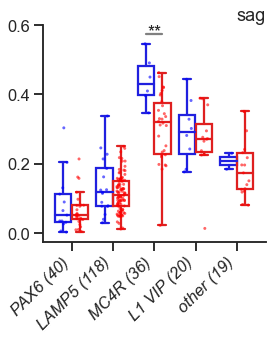

In [470]:
feat = ['sag']
utils.plot_boxplot_multiple(data, feat, groups, labels=feature_name, figsize=(4,4), 
                        plot_function=plot.plot_nested_comparisons, compare=compare, fdr_method=None, label_counts=True,
                            palette=epilepsy_palette
                           )

## morpho

In [21]:
data = human_df.query("l1_type & has_morph & condition!='hydrocephalus' & cortical_lobe=='TemL'")
# data = human_df.query("l1_type & has_morph & condition!='hydrocephalus' & homology_type!='L1 VIP'")
# data = human_df.query("l1_type & has_morph & condition!='hydrocephalus' & homology_type=='LAMP5' & layer=='1'")
# data = human_df.query("l1_type & has_morph & condition!='hydrocephalus' & collaborator=='AIBS'")
group_col = 'condition'

data = human_df.query("l1_type & has_morph & cortical_lobe=='TemL' & homology_type!='L1 VIP'")
data = human_df.query("l1_type & has_morph & cortical_lobe=='TemL' & homology_type=='LAMP5'")
data = human_df.query("l1_type & has_morph & structure=='MTG' & homology_type=='LAMP5'")
group_col = 'epileptic'
data[group_col].value_counts(dropna=False)

epileptic        12
non-epileptic     3
Name: epileptic, dtype: int64

In [22]:
features = morph_features
res = utils.run_twosamp(data, features, group_col, fdr_method='fdr_bh').sort_values('mw_r', ascending=False)
# res.to_csv(figdir/'supp_tables'/'md_medical_morpho.csv')
res.head(20)

/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/analysis.py:507: RuntimeWarning: invalid value encountered in double_scalars
  cohens_d = np.abs(np.mean(subsets[0]) - np.mean(subsets[1])) / np.std(df[feature])
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:339: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
axon_extent_x,0.004396,1.000000,1.000000,0.001142,1.887177,15,NaN,0.224176
axon_extent_x_over_y,0.008791,0.944444,0.972222,0.002341,1.806506,15,NaN,0.224176
basal_dendrite_num_branches,0.042748,0.805556,0.902778,0.047400,1.297635,15,NaN,0.493187
axon_max_euclidean_distance,0.048352,0.777778,0.888889,0.027767,1.415616,15,NaN,0.493187
axon_extent_y,0.048352,0.777778,0.888889,0.334795,0.669174,15,NaN,0.493187
axon_over_basal_dendrite_extent_x,0.070330,0.722222,0.861111,0.127873,1.027903,15,NaN,0.584579
axon_max_branch_order,0.080236,0.694444,0.847222,0.168619,0.937121,15,NaN,0.584579
soma_aligned_dist_from_pia,0.136264,0.611111,0.805556,0.305417,0.709376,15,NaN,0.868681
axon_bias_x,0.180220,0.555556,0.777778,0.013812,1.548309,15,NaN,0.959932


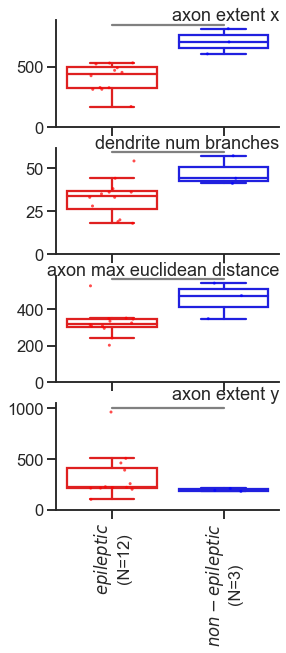

In [26]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res.index, corr, nfeat=4, threshold=0.7)
utils.plot_boxplot_multiple(data, feat, group_col, labels=feature_name, test='mannwhitney', figsize=(4,9), pairs='all',
                          palette=epilepsy_palette )

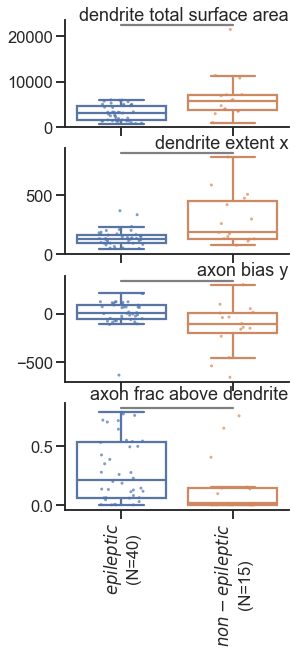

In [418]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res.index, corr, nfeat=4, threshold=0.7)
utils.plot_boxplot_multiple(data, feat, group_col, labels=feature_name, test='mannwhitney', figsize=(4,9), pairs='all')

### Interaction

In [455]:
data = human_df.query("l1_type & has_morph & cortical_lobe=='TemL'")
data = human_df.query("l1_type & has_morph")
groups='homology_type'
compare='epileptic'
data.groupby(groups)[compare].value_counts(dropna=False)

homology_type  epileptic    
PAX6           epileptic        11
               non-epileptic    10
LAMP5          epileptic        22
               non-epileptic    12
MC4R           non-epileptic     7
               epileptic         5
L1 VIP         epileptic         4
               non-epileptic     1
other          epileptic         4
               non-epileptic     3
Name: epileptic, dtype: int64

In [457]:
features = morph_features
res = utils.run_species_subclass_stats(data, features, compare=compare, group_var=groups, anova_type=1, 
                                       compare_first=False, )
res.head()

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1873: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 7
  'rank is %d' % (J, J_), ValueWarning)
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/statsmodels/base/model.py:1873: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
  'rank is %d' % (J, J_), ValueWarning)


,eta_p_epileptic,pval_epileptic,pval_homology_type:epileptic,rsquared,interaction
feature,,,,,
basal_dendrite_num_branches,0.275161,0.000136,0.659166,0.441530,False
basal_dendrite_total_surface_area,0.224777,0.000755,0.659166,0.328172,False
basal_dendrite_total_length,0.189166,0.002558,0.659166,0.311335,False
basal_dendrite_extent_x,0.104446,0.076212,0.352678,0.353841,False
basal_dendrite_mean_contraction,0.079167,0.136792,0.935342,0.195473,False


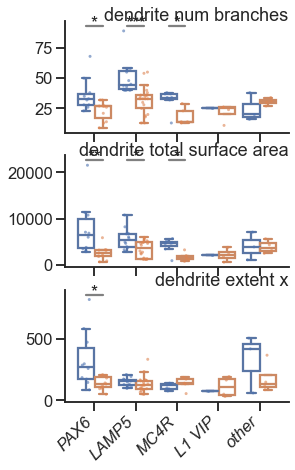

In [458]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res.loc[res.pval_epileptic<0.1].index, corr, nfeat=4, threshold=0.7)

utils.plot_boxplot_multiple(data, feat, groups, labels=feature_name, figsize=(4,7), 
                        plot_function=plot.plot_nested_comparisons, compare=compare, fdr_method=None,
                           )

In [29]:
data = human_df.query("l1_type & has_morph")
groups='reconstruction_type'
compare='epileptic'
data.groupby(groups)[compare].value_counts(dropna=False)

reconstruction_type  epileptic    
100x                 non-epileptic     8
                     epileptic         4
63x                  epileptic        42
                     non-epileptic    25
Name: epileptic, dtype: int64

In [30]:
features = morph_features
res = utils.run_species_subclass_stats(data, features, compare=compare, group_var=groups, anova_type=1, 
                                       compare_first=False, )
res.head()

,eta_p_epileptic,pval_epileptic,pval_reconstruction_type:epileptic,rsquared,interaction
feature,,,,,
basal_dendrite_num_branches,0.201858,0.001672,0.620751,0.222148,False
basal_dendrite_total_surface_area,0.192534,0.001672,0.886230,0.198547,False
basal_dendrite_total_length,0.139956,0.013655,0.866246,0.159841,False
basal_dendrite_mean_diameter,0.082845,0.122255,0.886230,0.148256,False
axon_frac_intersect_basal_dendrite,0.078322,0.122255,0.886230,0.082957,False


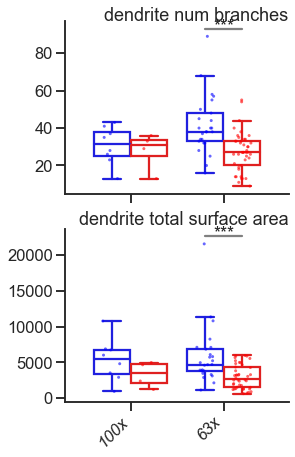

In [36]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res.loc[res.pval_epileptic<0.1].index, corr, nfeat=4, threshold=0.7)

utils.plot_boxplot_multiple(data, feat, groups, labels=feature_name, figsize=(4,7), 
                        plot_function=plot.plot_nested_comparisons, compare=compare, fdr_method=None,
                            palette=epilepsy_palette
                           )

In [373]:
data = human_df.query("l1_type & has_morph & cortical_lobe!='ParL'")
groups='cortical_lobe'
compare='epilepsy'
data.groupby(groups)[compare].value_counts(dropna=False)

cortical_lobe  epilepsy
Occ/FroL       False       14
               True         1
TemL           True        44
               False       15
Name: epilepsy, dtype: int64

In [387]:
res = utils.run_species_subclass_stats(data, features, compare=compare, group_var=groups, anova_type=1, 
                                       compare_first=False, )
res.head()

,eta_p_epilepsy,pval_epilepsy,pval_cortical_lobe:epilepsy,rsquared,interaction
feature,,,,,
basal_dendrite_extent_x,0.230596,0.001003,0.877722,0.255701,False
basal_dendrite_total_surface_area,0.215210,0.001034,0.947423,0.226292,False
basal_dendrite_total_length,0.176127,0.004128,0.988764,0.182318,False
basal_dendrite_max_euclidean_distance,0.141482,0.014393,0.988764,0.172600,False
basal_dendrite_max_path_distance,0.126822,0.021817,0.988764,0.140977,False


In [391]:
import patchseq_utils.plotting as plot

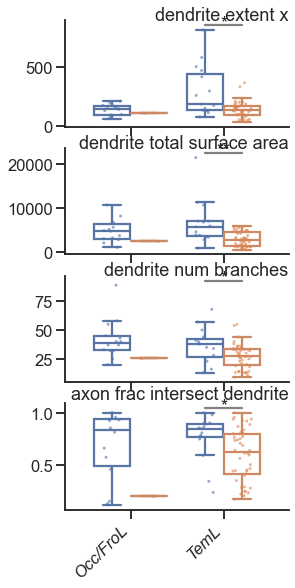

In [393]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res.index, corr, nfeat=4, threshold=0.7)

utils.plot_boxplot_multiple(data, feat, group_var, labels=feature_name, figsize=(4,9), 
                            plot_function=plot.plot_nested_comparisons, compare=compare, fdr_method='fdr_bh',
                           )

# sex

In [128]:
data = df.query("layer=='1'")
fisher_test_all(data, 'homology_type', group_col)

L1 VIP    0.016887
LAMP5     0.149690
PAX6      0.179659
MC4R      0.336454
other     1.000000
dtype: float64

In [125]:
pd.crosstab(data[group_col], df[cluster]=='VIP TSPAN12')

t-type,False,True
condition,,
epilepsy,142,8
tumor,32,7


In [118]:
data = subset_data(df.query("failed_fx_long_squares==False"),
                   ephys_features, cluster=group_col, ephys_frac_min=0, cluster_min=5)
data[group_col].value_counts(dropna=False)

epilepsy    190
tumor        46
Name: condition, dtype: int64

## ephys

In [190]:
data = human_df.query("l1_type & collaborator=='AIBS' & failed_fx_long_squares==False")
group_col = 'sex'
data[group_col].value_counts(dropna=False)

M    152
F     81
Name: sex, dtype: int64

In [191]:
features = subset_features(data, ephys_features, complete_frac=0.4)
res = utils.run_twosamp(data, features, group_col, fdr_method='fdr_bh')
res.to_csv(figdir/'supp_tables'/'md_sex_ephys.csv')
res.head(20)

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
rheobase_i,0.020864,0.181205,0.590603,0.504074,0.092360,233,0.939377,0.949167
threshold_i_ramp,0.041790,0.162293,0.581146,0.463485,0.101458,232,0.939377,0.949167
avg_rate_hero,0.075691,0.141407,0.570703,0.138265,0.204528,233,0.939377,0.949167
first_isi_inv_hero,0.097745,0.133121,0.566560,0.057583,0.264064,230,0.939377,0.949167
avg_rate_max,0.116475,0.125000,0.562500,0.120318,0.214296,233,0.939377,0.949167
width_adapt_ratio,0.129387,0.121070,0.560535,0.472520,0.099539,231,0.939377,0.949167
median_isi_hero,0.135135,0.120127,0.560064,0.331085,0.135556,230,0.939377,0.949167
vm_for_sag,0.162723,0.111192,0.555596,0.268796,0.152747,233,0.939377,0.949167
fi_fit_slope,0.171183,0.108999,0.554500,0.285832,0.147438,233,0.939377,0.949167


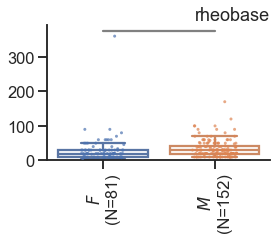

In [195]:
fig, ax = plt.subplots( figsize=(4,2.5))
utils.plot_box_cluster_feature(data, 'rheobase_i', group_col, label='rheobase', test='dunn', ax=ax)

## morpho

In [199]:
data = human_df.query("l1_type & has_morph & condition!='hydrocephalus'")
group_col = 'sex'
data[group_col].value_counts(dropna=False)

M    43
F    34
Name: sex, dtype: int64

In [200]:
features = morph_features
res = utils.run_twosamp(data, features, group_col, fdr_method='fdr_bh')
res.to_csv(figdir/'supp_tables'/'md_sex_morph.csv')
res.head(20)

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
axon_soma_percentile_y,0.064083,0.247606,0.623803,0.050261,0.450941,77,0.964098,0.945089
axon_bias_x,0.138259,0.198358,0.599179,0.622903,0.114635,77,0.964098,0.945089
axon_depth_pc_1,0.143799,0.195622,0.597811,0.148102,0.335073,77,0.964098,0.945089
axon_total_length,0.177353,0.180575,0.590287,0.109207,0.370511,77,0.964098,0.945089
axon_bias_y,0.184035,0.177839,0.588919,0.209718,0.291111,77,0.964098,0.945089
basal_dendrite_extent_x_over_y,0.190902,0.175103,0.587551,0.506412,0.154790,77,0.964098,0.945089
axon_extent_x,0.252713,0.153215,0.576607,0.866678,0.039164,77,0.987919,0.945089
axon_mean_contraction,0.256993,0.151847,0.575923,0.407051,0.192991,77,0.964098,0.945089
axon_depth_pc_2,0.270135,0.147743,0.573871,0.180597,0.310512,77,0.964098,0.945089


# age

## ephys

In [471]:
human_df['age_years'] = human_df['age'].map(lambda x: np.nan if x=='unknown' else int(x.split(' ')[0]))

In [475]:
human_df['age_years'].loc[lambda df: df<18]

spec_id
855683248    0.0
855683002    0.0
993416950    0.0
Name: age_years, dtype: float64

In [208]:
data = human_df.query("l1_type & collaborator=='AIBS' & failed_fx_long_squares==False")


In [213]:
group_col = 'age_years'
features = subset_features(data, ephys_features, complete_frac=0.4)
res = utils.run_correlations(data, features, group_col, fdr_method='fdr_bh')
res.to_csv(figdir/'supp_tables'/'md_age_ephys.csv')
res.head(20)

,r,pval,pval_fdr
feature,,,
peak_deltav_hero,-0.185535,0.004667,0.108141
upstroke_rheo,-0.180836,0.005845,0.108141
upstroke_hero,-0.165743,0.011640,0.125087
peak_v_hero,-0.162296,0.013523,0.125087
peak_deltav_short_square,-0.155260,0.018726,0.131759
peak_deltav_rheo,-0.143807,0.028875,0.131759
upstroke_short_square,-0.139959,0.034276,0.131759
avg_rate_hero,0.138905,0.034862,0.131759
upstroke_ramp,-0.138962,0.035186,0.131759


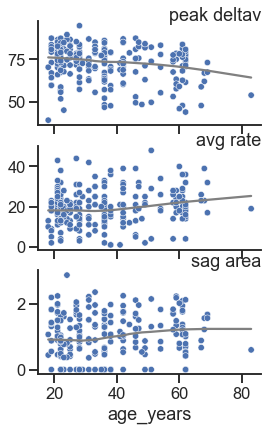

In [230]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res[res.pval<0.05].index, corr, nfeat=4, threshold=0.7)
utils.plot_boxplot_multiple(data, feat, group_col, labels=feature_name, plot_function=utils.plot_spearman, figsize=(4,6.5), stats=False, size=4)

## morpho

In [233]:
data = human_df.query("l1_type & has_morph & condition!='hydrocephalus'")

In [235]:
group_col = 'age_years'
features = morph_features
res = utils.run_correlations(data, features, group_col, fdr_method='fdr_bh')
res.to_csv(figdir/'supp_tables'/'md_age_morph.csv')
res.head(20)

,r,pval,pval_fdr
feature,,,
axon_bias_y,-0.293938,0.009467,0.321891
axon_depth_pc_4,-0.256929,0.024091,0.409548
axon_total_length,-0.217280,0.057671,0.445373
axon_num_branches,-0.193377,0.091975,0.445373
basal_dendrite_total_surface_area,0.188636,0.100386,0.445373
axon_exit_distance,-0.188195,0.101197,0.445373
axon_max_branch_order,-0.186493,0.104379,0.445373
basal_dendrite_total_length,0.186274,0.104794,0.445373
basal_dendrite_num_branches,0.160512,0.163165,0.612801


In [241]:
reload(utils)

<module 'patchseq_utils.analysis' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/analysis.py'>

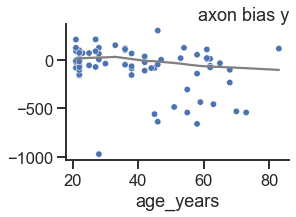

In [243]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res[res.pval<0.05].index, corr, nfeat=4, threshold=0.7)
feat = ['axon_bias_y']
utils.plot_boxplot_multiple(data, feat, group_col, labels=feature_name, plot_function=utils.plot_spearman, figsize=(4,2.5), stats=False, size=4)

# Lab / subclass proportions

** TODO: Try for FACS vs PS! **

In [35]:
data, clusters = subset_data(human_df.query('layer=="1" & collaborator=="Gabor" & tx_qc'), 
                                ephys_features, ephys_frac_min=0, cluster_min=0)
data[cluster].value_counts(dropna=False)

SST NMBR          5
NaN               4
PAX6 CDH12        4
GAD1 MC4R         3
LAMP5 LCP2        3
PAX6 TNFAIP8L3    2
VIP PCDH20        1
SST BAGE2         1
VIP TSPAN12       1
SST CHRNA4        1
LAMP5 DBP         1
Name: t-type, dtype: int64

In [14]:
data.loc[data[cluster].isna(), 'topLeaf'].value_counts()

Inh L1-4 VIP PENK            2
Inh L1-3 PAX6 SYT6 (Sncg)    1
Inh L1-3 VIP ADAMTSL1        1
Name: topLeaf, dtype: int64

In [48]:
df, _ = subset_data(human_df.query('layer=="1" & tx_qc & collaborator!="Huib"'), 
                    ephys_features, ephys_frac_min=0, cluster_min=0)
fisher_test_all(df, cluster, 'collaborator')

PAX6 TNFAIP8L3    0.054368
LAMP5 LCP2        0.165706
SST NMBR          0.244317
SST CHRNA4        0.590240
PAX6 CDH12        1.000000
GAD1 MC4R         1.000000
VIP TSPAN12       1.000000
VIP PCDH20        1.000000
LAMP5 DBP         1.000000
SST BAGE2         1.000000
dtype: float64

In [49]:
fisher_test_all(df, 'homology_type', 'collaborator')

Pax6           0.413058
Lamp5          0.656479
Rxrg           0.772370
Vip/Sncg       1.000000
other human    1.000000
dtype: float64

In [53]:
df, _ = subset_data(human_df.query('tx_qc & collaborator!="Huib"'), 
                    ephys_features, ephys_frac_min=0, cluster_min=0)
df[cluster].value_counts(dropna=False)

SST NMBR          97
PAX6 CDH12        52
GAD1 MC4R         40
LAMP5 LCP2        38
VIP TSPAN12       22
NaN               19
LAMP5 DBP         15
VIP PCDH20        14
SST BAGE2         14
SST CHRNA4        11
PAX6 TNFAIP8L3     6
Name: t-type, dtype: int64

In [50]:
fisher_test_all(df, cluster)

PAX6 TNFAIP8L3    0.093718
GAD1 MC4R         0.202603
VIP PCDH20        0.317173
LAMP5 LCP2        0.384049
SST CHRNA4        0.458934
SST BAGE2         0.743599
LAMP5 DBP         0.743599
PAX6 CDH12        1.000000
SST NMBR          1.000000
VIP TSPAN12       1.000000
dtype: float64

In [51]:
fisher_test_all(df, 'homology_type')

Rxrg           0.176053
Lamp5          0.319973
Pax6           0.584737
other human    0.619516
Vip/Sncg       1.000000
dtype: float64

In [57]:
df, _ = subset_data(human_df.query('tx_qc & collaborator!="Gabor"'), 
                    ephys_features, ephys_frac_min=0, cluster_min=0)
df[cluster].value_counts(dropna=False)

SST NMBR          85
PAX6 CDH12        45
LAMP5 LCP2        36
GAD1 MC4R         35
VIP TSPAN12       22
NaN               15
SST BAGE2         14
LAMP5 DBP         14
VIP PCDH20        13
SST CHRNA4        10
PAX6 TNFAIP8L3     3
Name: t-type, dtype: int64

In [58]:
fisher_test_all(df, cluster)

SST BAGE2         0.170430
GAD1 MC4R         0.230710
VIP TSPAN12       0.265036
SST CHRNA4        0.281674
VIP PCDH20        0.373389
SST NMBR          0.525424
PAX6 CDH12        0.593236
LAMP5 LCP2        1.000000
LAMP5 DBP         1.000000
PAX6 TNFAIP8L3    1.000000
dtype: float64

In [59]:
fisher_test_all(df, 'homology_type')

Rxrg           0.106333
Lamp5          0.243465
Vip/Sncg       0.265036
Pax6           0.436638
other human    1.000000
dtype: float64